In [1]:
import torch
import normflows as nf
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader as dl
from torch.utils.data import TensorDataset as ds
import torchvision as tv
import torch.nn as nn

In [2]:
enable_cuda = True
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
device

device(type='cuda')

In [3]:
number_of_dimensions = 28*28
number_of_color_chanels = 1
Height = 28
Width =28
base = nf.distributions.DiagGaussian((number_of_dimensions))

print(number_of_dimensions)

784


In [4]:
#Real NVP Model here
def Real_nvp_init():
    num_layers = 256
    Real_NVP_flows = []
    for i in range(num_layers):
        parameters = nf.nets.MLP([392,392],init_zeros=True)
        Real_NVP_flows.append(nf.flows.AffineCouplingBlock(param_map=parameters,scale=False))
        Real_NVP_flows.append(nf.flows.Permute(2,mode="swap"))

    Real_NVP_model = nf.NormalizingFlow(q0=base,flows=Real_NVP_flows)

    return Real_NVP_model

#favoured a lower learning rate of 0.0001

In [ ]:
def Real_nvp_init():
    num_layers = 256
    Real_NVP_flows = []
    
    for i in range(num_layers):
        # Define the convolutional layer
        conv_layer = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        # Define the MLP with the convolutional layer as input
        parameters = nn.Sequential(
            conv_layer,
            nn.Flatten(),
            nf.nets.MLP([16*392, 392, 392], init_zeros=True)
        )
        
        Real_NVP_flows.append(nf.flows.AffineCouplingBlock(param_map=parameters, scale=False))
        Real_NVP_flows.append(nf.flows.Permute(392, mode="swap"))

    Real_NVP_model = nf.NormalizingFlow(q0=base, flows=Real_NVP_flows)

    return Real_NVP_model

# Note: favoured a lower learning rate of 0.0001

In [5]:
#Neural Spline Flow
def Neural_Spline_init():
    K = 20
    torch.manual_seed(0)

    latent_size = number_of_dimensions
    hidden_units = 800
    hidden_layers = 2

    neural_flows = []
    for i in range(K):
        neural_flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units)]
        neural_flows += [nf.flows.LULinearPermute(latent_size)]


    Neural_Spline_model= nf.NormalizingFlow(q0=base, flows=neural_flows)

    return Neural_Spline_model

In [6]:
def MAF_init():
    MAF_flows = []
    hidden = 600 #number of hidden units
    
    latent_size = number_of_dimensions
    
    K=16

    for i in range(K):
        MAF_flows += [nf.flows.MaskedAffineAutoregressive(latent_size, hidden)]
        MAF_flows += [nf.flows.Permute(2,mode="swap")]

    MAF_model = nf.NormalizingFlow(q0=base,flows=MAF_flows)

    return MAF_model

In [7]:
def RotationalQuadraticSpline_init():
    K = 16

    latent_size = number_of_dimensions
    hidden_units = 1000
    hidden_layers = 2

    flows = []
    for i in range(K):
        flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units)]
        flows += [nf.flows.LULinearPermute(latent_size)]

    # Set base distribution
    q0 = base
        
    # Construct flow model
    RotationalQuadraticSpline_model = nf.NormalizingFlow(q0, flows)

    return RotationalQuadraticSpline_model

In [8]:
transform = tv.transforms.Compose(
    [
        tv.transforms.ToTensor(),
        tv.transforms.Normalize((0.5,),(0.5,)), #will need to change normalization for 3 chanel
    ]   
)
batch_size =256

In [9]:
trainset =tv.datasets.MNIST(root='./data',train=True,download=True,transform=transform)

trainloader = dl(trainset,batch_size=batch_size,shuffle=True)


In [10]:
def train_model(model,learning_rate):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-7) 
    tolerance = 0.0001
    previous_loss = float('inf')
    early_stop = False
    losses = []
        
    for epoch in tqdm(range(10)):
            model.train()
            for data,label in trainloader:
                optimizer.zero_grad()
                data = data[:, 0, :, :].flatten(start_dim=1).to(device)
                loss = model.forward_kld(data)
                    
                if ~(torch.isnan(loss) | torch.isinf(loss)):
                    loss.backward()
                    optimizer.step()
                    
                current_loss = loss.item()
                    
                if epoch > 0:
                    loss_diff = abs(current_loss - previous_loss)
                    if loss_diff < tolerance:
                        early_stop = True
                        print(f"Early stopping at epoch {epoch+1} with loss difference {loss_diff:.6f}")
                        break
                    
                losses.append(loss.item())
                    
                previous_loss = current_loss
        
    plt.figure()
    plt.plot(losses)
    plt.show()
    return model

In [11]:
Models = [Real_nvp_init(),Neural_Spline_init(),RotationalQuadraticSpline_init()]
for model in Models:
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])

    print(f'model has {params} trainable parameters')

model has 387522080 trainable parameters
model has 365007008 trainable parameters
model has 375273120 trainable parameters


100%|██████████| 10/10 [10:00<00:00, 60.08s/it]
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/mnt/sw/nix/store/71ksmx7k6xy3v9ksfkv5mp5kxxp64pd6-python-3.10.13-view/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


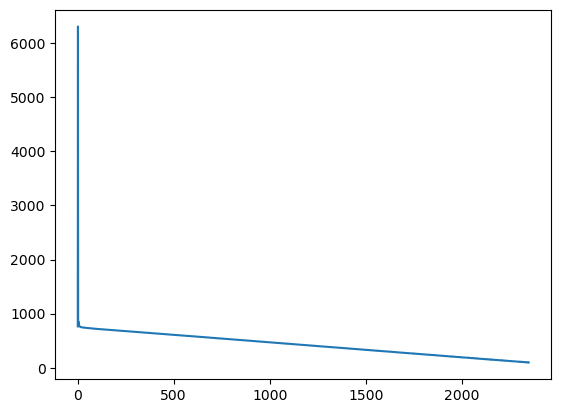

100%|██████████| 10/10 [34:32<00:00, 207.21s/it]


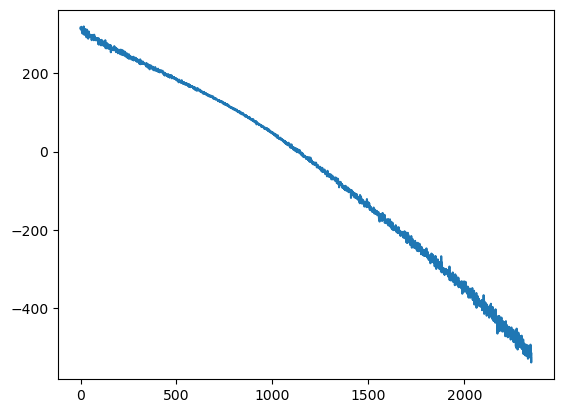

100%|██████████| 10/10 [28:25<00:00, 170.51s/it]


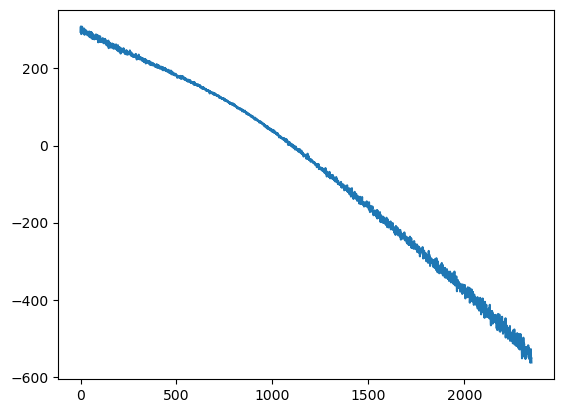

In [12]:
trained_models = []

for i in range(len(Models)):
    if i == 0:
        rate = 0.00041
    else:
        rate = 1e-6 #best so far has been 1e-4
    trained_models.append(train_model(Models[i],rate))

In [17]:
def generate_and_print_images(model, device, num_images=5):
    model.eval()  

    with torch.no_grad():
        z = torch.randn(num_images, number_of_dimensions).to(device)  
        generated_images = model(z)

    # for image in generated_images:
    #     for i in range(len(image)):
    #         if (image[i])>=0.5:
    #             image[i]=1
    #         else:
    #             image[i]=0

    generated_images = (generated_images * 0.5 )+ 0.5
    generated_images = generated_images.view(-1, 1, Height, Width)  


    plt.figure(figsize=(10, 10))
    plt.axis("off")
    plt.title("Generated Images")
    plt.imshow(tv.utils.make_grid(generated_images.cpu(), nrow=10, normalize=False).permute(1, 2, 0))
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


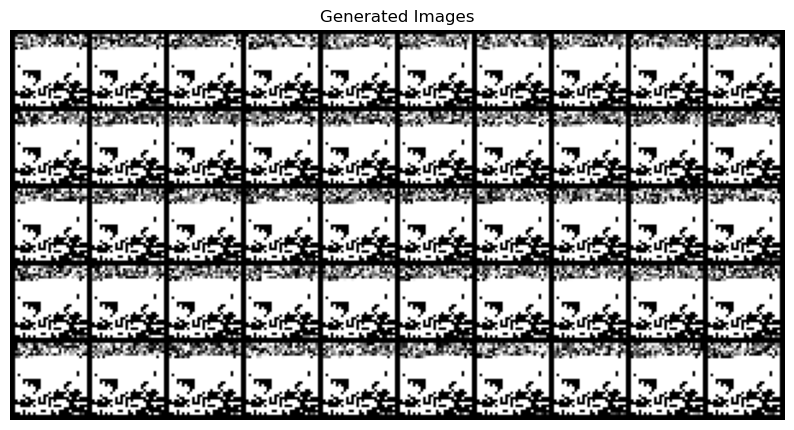

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


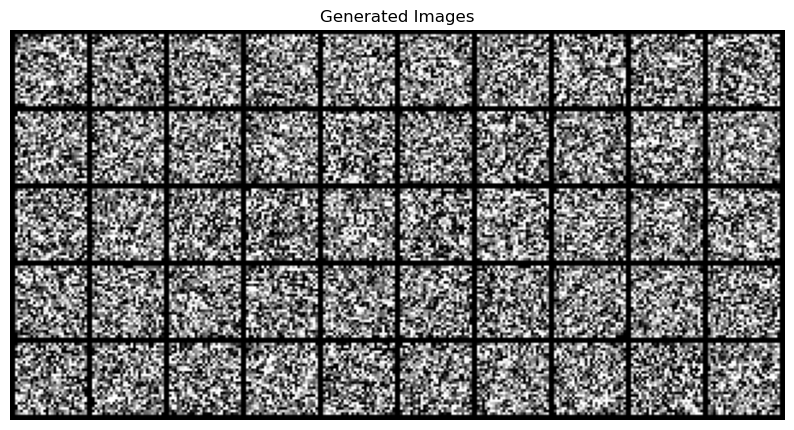

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


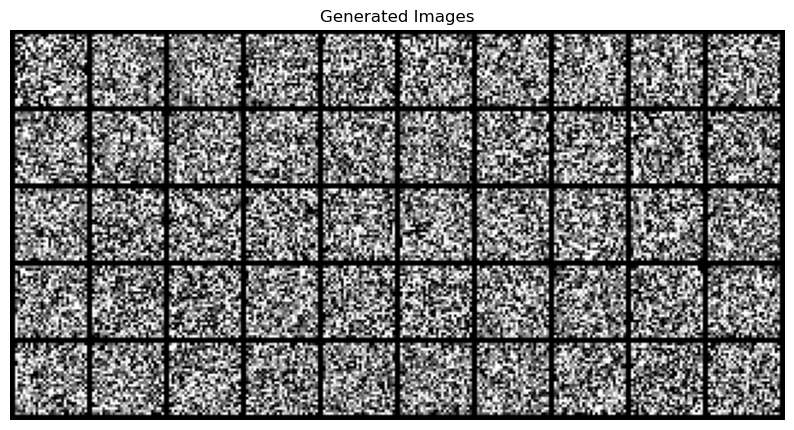

In [18]:
for trained_model in trained_models:
    generate_and_print_images(trained_model, device, num_images=50)

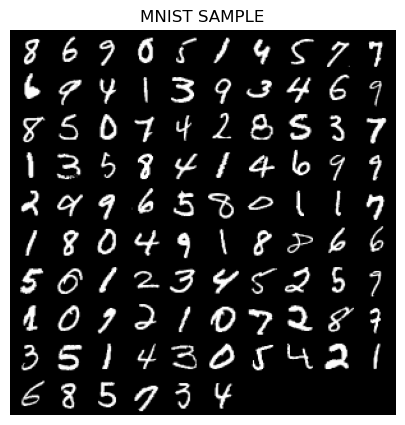

In [ ]:
for data,label in trainloader:
    data = data[:, 0, :, :].flatten(start_dim=1).to(device)
    generated_images = data 
    generated_images = generated_images.view(-1, 1, 28, 28)
    #generated_images = generated_images.expand(-1, 3, -1, -1)
    generated_images = (generated_images * 0.5 )+ 0.5  # Denormalize images

plt.figure(figsize=(10, 5))
plt.axis("off")
plt.title("MNIST SAMPLE")
plt.imshow(tv.utils.make_grid(generated_images.cpu(), nrow=10, normalize=True).permute(1, 2, 0))
plt.show()